## 1. Setup dan Import Library

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import warnings
import joblib
import json
import torch.onnx
import onnx
import onnxruntime as ort
import os



warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2. Load Data

In [ ]:
data_path = '../data/processed/daily_trends_processed_20251221_183209.csv'

df = pd.read_csv(data_path)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['keyword', 'category', 'date'])

print(f"Shape data: {df.shape}")
print(f"Rentang tanggal: {df['date'].min()} sampai {df['date'].max()}")
print(f"Jumlah keywords: {df['keyword'].nunique()}")
print(f"Jumlah categories: {df['category'].nunique()}")

df.head()

## 3. Sequence

In [ ]:
LOOKBACK = 14 
FORECAST_HORIZON = 7  
def create_sequences(data, lookback, forecast_horizon):
    """
    Buat sequences untuk LSTM training
    """
    X, y = [], []
    
    for i in range(len(data) - lookback - forecast_horizon + 1):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+forecast_horizon])
    
    return np.array(X), np.array(y)

print(f"Parameter sequences:")
print(f"  Lookback: {LOOKBACK} hari")
print(f"  Forecast horizon: {FORECAST_HORIZON} hari")

## 4. Data Prep

In [ ]:

scaler = MinMaxScaler(feature_range=(0, 1))
all_values = df['interest_value'].values.reshape(-1, 1)
scaler.fit(all_values)

all_X = []
all_y = []
keyword_count = 0

for keyword in df['keyword'].unique():
    for category in df[df['keyword'] == keyword]['category'].unique():
        keyword_data = df[
            (df['keyword'] == keyword) & 
            (df['category'] == category)
        ].copy().sort_values('date')
        
        if len(keyword_data) < LOOKBACK + FORECAST_HORIZON + 1:
            continue
        values = keyword_data['interest_value'].values.reshape(-1, 1)
        scaled_values = scaler.transform(values)
        X, y = create_sequences(scaled_values, LOOKBACK, FORECAST_HORIZON)
        
        if len(X) > 0:
            all_X.append(X)
            all_y.append(y)
            keyword_count += 1
X = np.concatenate(all_X, axis=0)
y = np.concatenate(all_y, axis=0)

print(f"\nTotal sequences: {X.shape[0]}")
print(f"Dari {keyword_count} keyword-category combinations")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

## 5. Train/Test Split

In [ ]:
indices = np.random.permutation(len(X))
X = X[indices]
y = y[indices]

split_idx = int(len(X) * 0.8)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Train set: {X_train.shape[0]} sequences")
print(f"Test set: {X_test.shape[0]} sequences")

## 6. Flatten Target

In [ ]:
y_train_flat = y_train.reshape(y_train.shape[0], -1)
y_test_flat = y_test.reshape(y_test.shape[0], -1)

print(f"Reshaped for training:")
print(f"  y_train_flat: {y_train_flat.shape}")
print(f"  y_test_flat: {y_test_flat.shape}")

## 7. Model LSTM

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, lookback, forecast_horizon):
        super(LSTMModel, self).__init__()
        self.lookback = lookback
        self.forecast_horizon = forecast_horizon
        
        # LSTM layers 
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=128, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        
        # Dense layers
        self.fc1 = nn.Linear(64, 32)
        self.relu = nn.ReLU()
        self.dropout3 = nn.Dropout(0.1)
        
        # Output layer
        self.fc2 = nn.Linear(32, forecast_horizon)
    
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        
        x, (h_n, c_n) = self.lstm2(x)
        x = self.dropout2(x)
        
        x = h_n[-1]
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        x = self.fc2(x)
        return x

# Build model
model = LSTMModel(LOOKBACK, FORECAST_HORIZON).to(device)

print("Arsitektur Model:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

## 8. Training

In [8]:
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train_flat).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test_flat).to(device)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Loss dan optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.8,
    patience=30,
    min_lr=1e-5,
    verbose=True
)

# Training parameters
num_epochs = 500
best_val_loss = float('inf')
patience = 100
patience_counter = 0
min_delta = 0  

history = {'train_loss': [], 'val_loss': [], 'train_mae': [], 'val_mae': [], 'lr': []}

print(f"Device: {device}")
print(f"Training samples: {len(X_train)}")
print(f"Early stopping patience: {patience} epochs")
print(f"Min delta threshold: {min_delta} (any improvement counts!)\n")

Device: cpu
Training samples: 2880
Early stopping patience: 100 epochs
Min delta threshold: 0 (any improvement counts!)



In [9]:
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    train_maes = []
    
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        train_maes.append(torch.abs(outputs - batch_y).mean().item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()
        val_mae = torch.abs(val_outputs - y_test_tensor).mean().item()

    train_loss = np.mean(train_losses)
    train_mae = np.mean(train_maes)
    current_lr = optimizer.param_groups[0]['lr']
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_mae'].append(train_mae)
    history['val_mae'].append(val_mae)
    history['lr'].append(current_lr)
    
    scheduler.step(val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Val MAE: {val_mae:.4f}, LR: {current_lr:.6f}")
    
    improvement = best_val_loss - val_loss
    if improvement > min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), '../models/daily/lstm/lstm_daily_pytorch.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final learning rate: {optimizer.param_groups[0]['lr']:.6f}")

model.load_state_dict(torch.load('../models/daily/lstm/lstm_daily_pytorch.pth', weights_only=True))

Epoch [10/500] - Train Loss: 0.0190, Val Loss: 0.0123, Val MAE: 0.0803, LR: 0.001000
Epoch [20/500] - Train Loss: 0.0169, Val Loss: 0.0121, Val MAE: 0.0812, LR: 0.001000
Epoch [30/500] - Train Loss: 0.0160, Val Loss: 0.0121, Val MAE: 0.0809, LR: 0.001000
Epoch [40/500] - Train Loss: 0.0148, Val Loss: 0.0124, Val MAE: 0.0812, LR: 0.001000
Epoch [50/500] - Train Loss: 0.0129, Val Loss: 0.0097, Val MAE: 0.0708, LR: 0.001000
Epoch [60/500] - Train Loss: 0.0122, Val Loss: 0.0104, Val MAE: 0.0735, LR: 0.001000
Epoch [70/500] - Train Loss: 0.0114, Val Loss: 0.0093, Val MAE: 0.0701, LR: 0.001000
Epoch [80/500] - Train Loss: 0.0112, Val Loss: 0.0089, Val MAE: 0.0663, LR: 0.001000
Epoch [90/500] - Train Loss: 0.0107, Val Loss: 0.0087, Val MAE: 0.0665, LR: 0.001000
Epoch [100/500] - Train Loss: 0.0105, Val Loss: 0.0085, Val MAE: 0.0654, LR: 0.001000
Epoch [110/500] - Train Loss: 0.0100, Val Loss: 0.0084, Val MAE: 0.0640, LR: 0.001000
Epoch [120/500] - Train Loss: 0.0098, Val Loss: 0.0085, Val MAE

<All keys matched successfully>

## 9. Training History

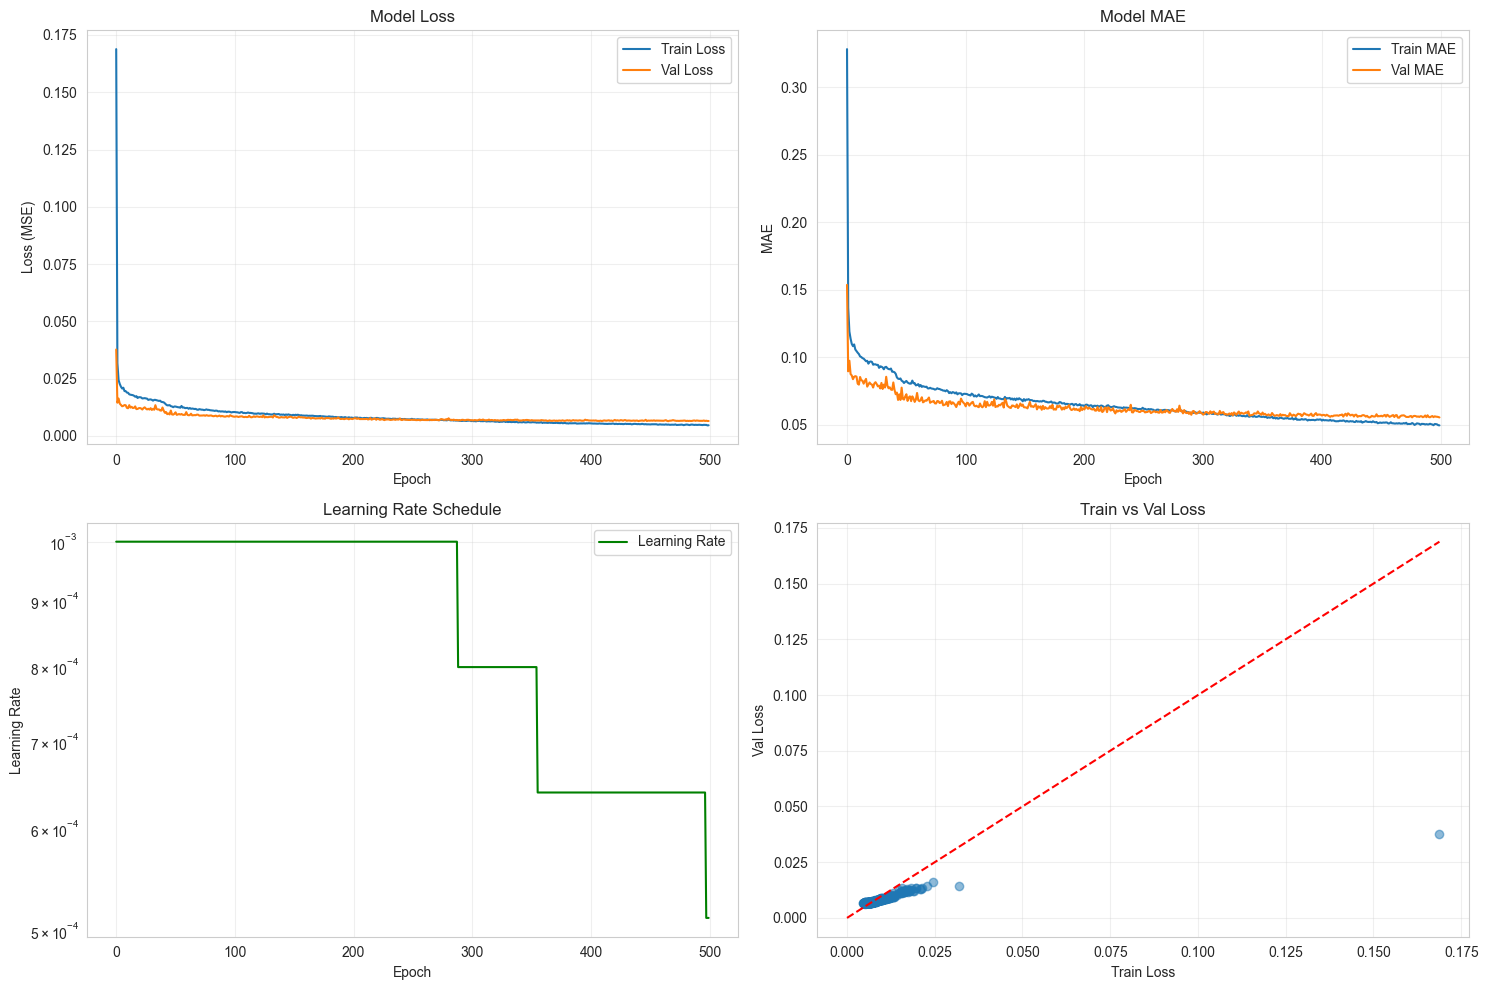

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history['train_loss'], label='Train Loss')
axes[0, 0].plot(history['val_loss'], label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].set_title('Model Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history['train_mae'], label='Train MAE')
axes[0, 1].plot(history['val_mae'], label='Val MAE')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_title('Model MAE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(history['lr'], label='Learning Rate', color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_yscale('log')

axes[1, 1].scatter(history['train_loss'], history['val_loss'], alpha=0.5)
min_val = 0
max_val = max(max(history['train_loss']), max(history['val_loss']))
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--')
axes[1, 1].set_xlabel('Train Loss')
axes[1, 1].set_ylabel('Val Loss')
axes[1, 1].set_title('Train vs Val Loss')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Evaluasi Model

In [14]:
# Prediksi
model.eval()
with torch.no_grad():
    y_pred_train_tensor = model(X_train_tensor)
    y_pred_test_tensor = model(X_test_tensor)

# Convert back to numpy
y_pred_train = y_pred_train_tensor.cpu().numpy()
y_pred_test = y_pred_test_tensor.cpu().numpy()

# Inverse transform
y_train_inv = scaler.inverse_transform(y_train_flat)
y_test_inv = scaler.inverse_transform(y_test_flat)
y_pred_train_inv = scaler.inverse_transform(y_pred_train)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)

# Hitung metrik
def calculate_metrics(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mean_actual = y_true.mean()
    error_pct = (mae / mean_actual) * 100
    
    print(f"\nMetrik {dataset_name}:")
    print(f"  MAE:      {mae:.4f}")
    print(f"  RMSE:     {rmse:.4f}")
    print(f"  R2:       {r2:.4f}")
    print(f"  Error %:  {error_pct:.2f}%")
    
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Error_Pct': error_pct}

print("HASIL EVAL LSTM")
train_metrics = calculate_metrics(y_train_inv, y_pred_train_inv, "Train")
test_metrics = calculate_metrics(y_test_inv, y_pred_test_inv, "Test")

HASIL EVAL LSTM

Metrik Train:
  MAE:      4.3475
  RMSE:     6.1464
  R2:       0.9185
  Error %:  6.86%

Metrik Test:
  MAE:      5.5102
  RMSE:     8.0336
  R2:       0.8644
  Error %:  8.66%


## 11. Visualisasi

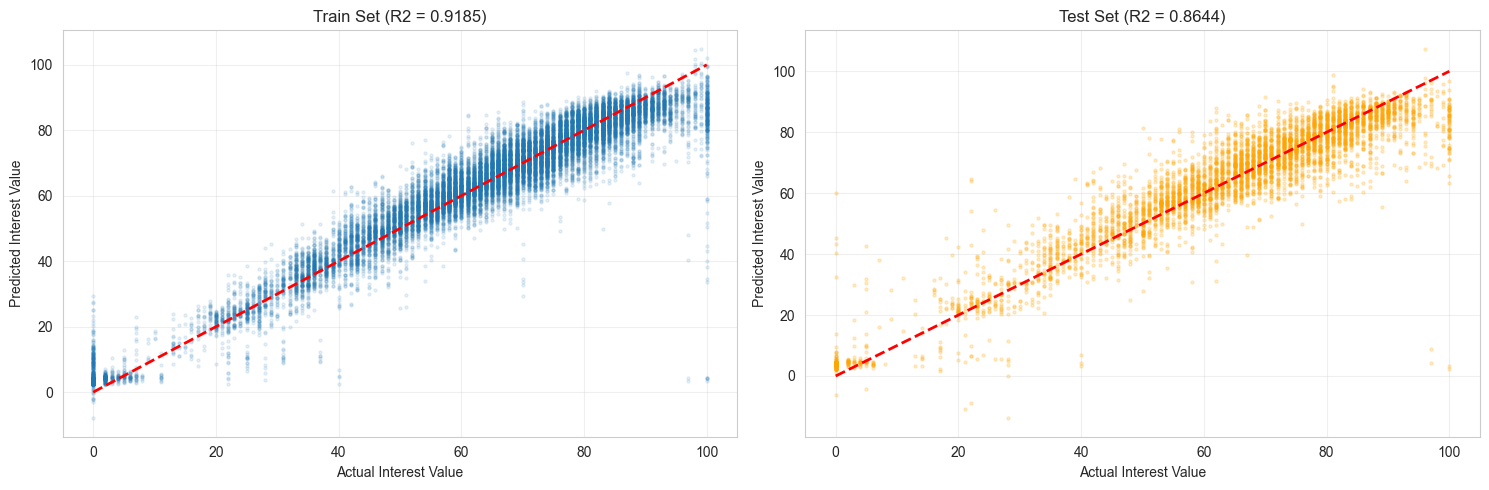

In [12]:
# Scatter plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(y_train_inv.flatten(), y_pred_train_inv.flatten(), alpha=0.1, s=5)
axes[0].plot([0, 100], [0, 100], 'r--', lw=2)
axes[0].set_xlabel('Actual Interest Value')
axes[0].set_ylabel('Predicted Interest Value')
axes[0].set_title(f'Train Set (R2 = {train_metrics["R2"]:.4f})')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_test_inv.flatten(), y_pred_test_inv.flatten(), alpha=0.2, s=5, color='orange')
axes[1].plot([0, 100], [0, 100], 'r--', lw=2)
axes[1].set_xlabel('Actual Interest Value')
axes[1].set_ylabel('Predicted Interest Value')
axes[1].set_title(f'Test Set (R2 = {test_metrics["R2"]:.4f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Save Model

In [16]:
joblib.dump(scaler, '../models/daily/lstm/lstm_daily_7days_scaler.pkl')

metrics = {
    'model': 'LSTM (PyTorch) - All Keywords',
    'forecast_horizon': '7 days',
    'lookback': LOOKBACK,
    'train': train_metrics,
    'test': test_metrics,
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'architecture': 'LSTM 128->64 + Dense 32',
    'training': {
        'epochs_run': len(history['train_loss']),
        'best_val_loss': best_val_loss,
        'final_lr': history['lr'][-1]
    }
}

with open('../models/daily/lstm/lstm_daily_7days_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

## 11. Save Model ONNX

In [ ]:
os.makedirs('../models', exist_ok=True)

torch_path = '../models/daily/lstm/onnx/lstm_daily.pth'
torch.save(model.state_dict(), torch_path)

try:

    input_size = X_train.shape[2] 
    seq_len = 14 
    
    dummy_input = torch.randn(1, seq_len, input_size).to(device)
    model.eval()
    
    onnx_path = '../models/daily/lstm/onnx/lstm_daily.onnx'
    
    torch.onnx.export(model,
                      dummy_input,
                      onnx_path,
                      export_params=True,
                      opset_version=11,
                      do_constant_folding=True,
                      input_names = ['input_sequence'],
                      output_names = ['prediction'],
                      dynamic_axes={'input_sequence' : {0 : 'batch_size'},
                                    'prediction' : {0 : 'batch_size'}})

except Exception as e:
    print(f"  ERROR exporting to ONNX: {str(e)}")

try:
    if not os.path.exists(onnx_path):
        raise FileNotFoundError("ONNX file not found")
        
    session = ort.InferenceSession(onnx_path)
    input_name = session.get_inputs()[0].name

    X_sample_torch = X_test_tensor[:1]
    X_sample_numpy = X_sample_torch.cpu().numpy()

    with torch.no_grad():
        pred_torch = model(X_sample_torch).cpu().numpy()

    pred_onnx = session.run(None, {input_name: X_sample_numpy})[0]
    
    print(f"  PyTorch prediction: {pred_torch.flatten()}")
    print(f"  ONNX prediction:    {pred_onnx.flatten()}")
    
    if np.allclose(pred_torch, pred_onnx, rtol=1e-4):
        print("  SUCCESS: Predictions match!")
    else:
        print("  WARNING: Prediction mismatch")

except Exception as e:
    print(f"  Validation skipped/failed: {str(e)}")


  PyTorch prediction: [0.57323164 0.7187231  0.71835035 0.7472662  0.7459754  0.63612026
 0.5244874 ]
  ONNX prediction:    [0.5732316  0.7187231  0.71835035 0.7472661  0.7459754  0.6361203
 0.52448744]
  SUCCESS: Predictions match!


: 